# 화재발생 예측모델 개발

## 배경
김해지역은 화재가 계절 및 장소 등에 관계 없이 잇따라 발생하고 있어 시민의 인명과 재산의 피해를 줄이기 위한 다양한 대책이 요구됨

## 목적
김해시에서는 소방 및 건물관련 정보를 융합하여 지역 내 화재 위험도에 대해 분석 및 예측하고 이를 이용하여 화재에 대한 집중적이고 적극적인 예방활동을 수행

## 해결과제
김해시가 수집한 소방 및 건물 관련 데이터를 활용하여 **건축물의 화재 위험도 분석** 및 **예측 모델 제시**


### 주어진 데이터 파일
- train.csv: 경상남도 지역
- validation.csv: 김해시 지역으로 한정
- test.csv: 김해시 지역 한정

(train set 은 김해시를 제외한 경남지역, validation, test set은 김해시 지역)
https://compas.lh.or.kr/subj/past/data?subjNo=SBJ_1910_002

In [104]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import re

## LOAD DATA

In [105]:
DATA_PATH = "./SBJ_1910_002/"
TRAIN_FILENAME = "train.csv"
TEST_FILENAME = "test.csv"
VAL_FILENAME = "validation.csv"
train_df = pd.read_csv(os.path.join(DATA_PATH, TRAIN_FILENAME))
test_df = pd.read_csv(os.path.join(DATA_PATH, TEST_FILENAME))
val_df = pd.read_csv(os.path.join(DATA_PATH, VAL_FILENAME))

/home/minsungkim/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8,172,173,174,175,176,177,178,179) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [106]:
train_df.shape, test_df.shape, val_df.shape

((59199, 180), (2957, 180), (6898, 180))

홈페이지 상의 컬럼의 개수는 63개이다. 실제 데이터에서는 180개.

결국 예측해야 하는 것은 **fr_yn**인 화재 발생 여부를 예측해야 한다.

In [107]:
train_df.head()

,dt_of_fr,fr_yn,bldng_us,bldng_archtctr,bldng_cnt,bldng_ar,ttl_ar,lnd_ar,dt_of_athrztn,ttl_grnd_flr,...,no_tbc_zn_dstnc,bldng_cnt_in_50m,trgt_crtr,fr_fghtng_fclt_spcl_css_5_yn,fr_fghtng_fclt_spcl_css_6_yn,us_yn,dngrs_thng_yn,slf_fr_brgd_yn,blk_dngrs_thng_mnfctr_yn,cltrl_hrtg_yn
0,2017-10-20 05:54,Y,단독주택,블록구조,3,69.42,69.42,0.0,1977,1.0,...,88,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-09-30 08:26,N,NaN,NaN,3,46.29,46.29,0.0,NaN,1.0,...,7727,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-10-30 14:57,Y,공동주택,철근콘크리트구조,1,583.80,2516.76,1446.0,2.00011e+07,5.0,...,72,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-06-14 05:23,N,단독주택,일반목구조,2,48.92,48.92,0.0,1936,1.0,...,508,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-04-22 05:38,N,NaN,NaN,2,0.00,0.00,0.0,NaN,NaN,...,707,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
print("length of columns: ", len(train_df.columns))
print(train_df.columns)

length of columns:  180
Index(['dt_of_fr', 'fr_yn', 'bldng_us', 'bldng_archtctr', 'bldng_cnt',
       'bldng_ar', 'ttl_ar', 'lnd_ar', 'dt_of_athrztn', 'ttl_grnd_flr',
       ...
       'no_tbc_zn_dstnc', 'bldng_cnt_in_50m', 'trgt_crtr',
       'fr_fghtng_fclt_spcl_css_5_yn', 'fr_fghtng_fclt_spcl_css_6_yn', 'us_yn',
       'dngrs_thng_yn', 'slf_fr_brgd_yn', 'blk_dngrs_thng_mnfctr_yn',
       'cltrl_hrtg_yn'],
      dtype='object', length=180)


## Preprocessing

In [109]:
(train_df.shape[1], test_df.shape[1], val_df.shape[1]) == (180, 180, 180)

True

In [110]:
# train_df.shape[1], test_df.shape[1], val_df.shape[1] == 180
# 전체 설명이 있는 컬럼은 62개 (id 포함)

og_col_li = train_df.columns
print("number of original df columns:", len(og_col_li))

number of original df columns: 180


In [111]:
need_li = ["id",
"dt_of_fr",
"fr_yn",
"bldng_us",
"bldng_archtctr",
"bldng_cnt",
"bldng_ar",
"ttl_ar",
"lnd_ar",
"dt_of_athrztn",
"ttl_grnd_flr",
"ttl_dwn_flr",
"bldng_us_clssfctn",
"tmprtr",
"prcpttn",
"wnd_spd",
"wnd_drctn",
"hmdt",
"ele_engry_us_201401",
"ele_engry_us_201812",
"gas_engry_us_201401",
"gas_engry_us_201812",
"lw_13101010",
"lw_13101110",
"lw_13101210",
"lw_13101211",
"lw_13101310",
"lw_13111010",
"lw_13101410",           
"lw_13111110",
"lw_13121010",
"lw_13121011",
"lw_13131010",
"lw_13131110",
"lw_13141010",
"lw_13141011",
"jmk",
"rgnl_ar_nm",
"rgnl_ar_nm2",
"lnd_us_sttn_nm",
"rd_sd_nm",
"emd_nm",
"hm_cnt",
"fr_sttn_dstnc",
"bldng_ar_prc",
"fr_wthr_fclt_dstnc",
"fr_mn_cnt",
"mlt_us_yn",
"cctv_dstnc",
"cctv_in_100m",
"fr_wthr_fclt_in_100m",
"tbc_rtl_str_dstnc",
"sft_emrgnc_bll_dstnc",
"ahsm_dstnc",
"no_tbc_zn_dstnc",
"trgt_crtr",
"fr_fghtng_fclt_spcl_css_5_yn",
"fr_fghtng_fclt_spcl_css_6_yn",
"us_yn",
"dngrs_thng_yn",
"slf_fr_brgd_yn",
"blk_dngrs_thng_mnfctr_yn",
"cltrl_hrtg_yn"]

In [112]:
sub_li = [col for col in og_col_li.tolist() if col not in need_li]
print("number of sub list:", len(sub_li))
print("number of need list:", len(need_li))
print(len(sub_li) + len(need_li))

number of sub list: 117
number of need list: 63
180


In [113]:
# 118 columns : 시기별 (201402 ~ 201811) 전기, 가스 사용량이다. 
print(sub_li)

['gas_engry_us_201402', 'ele_engry_us_201402', 'gas_engry_us_201403', 'ele_engry_us_201403', 'gas_engry_us_201404', 'ele_engry_us_201404', 'gas_engry_us_201405', 'ele_engry_us_201405', 'gas_engry_us_201406', 'ele_engry_us_201406', 'gas_engry_us_201407', 'ele_engry_us_201407', 'gas_engry_us_201408', 'ele_engry_us_201408', 'gas_engry_us_201409', 'ele_engry_us_201409', 'gas_engry_us_201410', 'ele_engry_us_201410', 'gas_engry_us_201411', 'ele_engry_us_201411', 'gas_engry_us_201412', 'ele_engry_us_201412', 'gas_engry_us_201501', 'ele_engry_us_201501', 'gas_engry_us_201502', 'ele_engry_us_201502', 'gas_engry_us_201503', 'ele_engry_us_201503', 'gas_engry_us_201504', 'ele_engry_us_201504', 'gas_engry_us_201505', 'ele_engry_us_201505', 'gas_engry_us_201506', 'ele_engry_us_201506', 'gas_engry_us_201507', 'ele_engry_us_201507', 'gas_engry_us_201508', 'ele_engry_us_201508', 'gas_engry_us_201509', 'ele_engry_us_201509', 'gas_engry_us_201510', 'ele_engry_us_201510', 'gas_engry_us_201511', 'ele_engry

In [114]:
# Save the 'Id' column
train_id = train_df["id"]
test_id = test_df["id"]
val_id = val_df["id"]
# Drop the "Id" column since it's not necessary for the prediction.
train_df.drop("id", axis=1, inplace=True)
test_df.drop("id", axis=1, inplace=True)
val_df.drop("id", axis=1, inplace=True)

In [115]:
print(train_df.shape, test_df.shape, val_df.shape)

# train, val_df의 fr_yn은 모두 존재
print(train_df.fr_yn.isnull().sum(), val_df.fr_yn.isnull().sum())

# test_df.fr_yn, 예측해야 하는 값이므로 모두 비어 있다.
print(test_df.shape[0], test_df.fr_yn.isnull().sum())

(59199, 179) (2957, 179) (6898, 179)
0 0
2957 2957


In [116]:
# 전체 전처리 이후 나누기 위한 위치를 저장
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
nval = val_df.shape[0]

y_train = train_df.fr_yn.values
all_df = pd.concat((train_df, val_df, test_df)).reset_index(drop=True)
all_df.drop(["fr_yn"], axis=1, inplace=True)
print("all_df size is : {}".format(all_df.shape))

all_df size is : (69054, 178)


In [117]:
all_df

,dt_of_fr,bldng_us,bldng_archtctr,bldng_cnt,bldng_ar,ttl_ar,lnd_ar,dt_of_athrztn,ttl_grnd_flr,ttl_dwn_flr,...,no_tbc_zn_dstnc,bldng_cnt_in_50m,trgt_crtr,fr_fghtng_fclt_spcl_css_5_yn,fr_fghtng_fclt_spcl_css_6_yn,us_yn,dngrs_thng_yn,slf_fr_brgd_yn,blk_dngrs_thng_mnfctr_yn,cltrl_hrtg_yn
0,2017-10-20 05:54,단독주택,블록구조,3,69.42,69.42,0.0,1977,1.0,0.0,...,88,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-09-30 08:26,NaN,NaN,3,46.29,46.29,0.0,NaN,1.0,0.0,...,7727,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-10-30 14:57,공동주택,철근콘크리트구조,1,583.80,2516.76,1446.0,2.00011e+07,5.0,0.0,...,72,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-06-14 05:23,단독주택,일반목구조,2,48.92,48.92,0.0,1936,1.0,0.0,...,508,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-04-22 05:38,NaN,NaN,2,0.00,0.00,0.0,NaN,NaN,NaN,...,707,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69049,2018-05-31 19:17,단독주택,철근콘크리트구조,1,122.45,329.55,288.0,2.00108e+07,3.0,0.0,...,183,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69050,2014-10-17 18:20,NaN,NaN,4,52.89,52.89,0.0,NaN,1.0,0.0,...,590,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69051,2015-08-25 15:13,단독주택,철근콘크리트구조,1,166.05,466.82,277.3,2.01208e+07,3.0,0.0,...,105,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69052,2015-05-27 23:00,자동차관련시설,경량철골구조,1,250.00,240.00,827.8,2.00908e+07,1.0,0.0,...,806,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 'dt_of_yn' bar chart

In [118]:
all_df["month"] = pd.to_datetime(train_df['dt_of_fr']).dt.month
all_df["year"] = pd.to_datetime(train_df['dt_of_fr']).dt.year

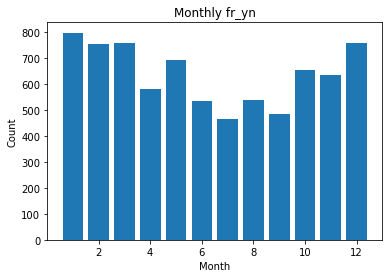

In [119]:
train_dt_y = train_df[train_df["fr_yn"] == "Y"][["dt_of_fr", "fr_yn"]]
train_dt_y["month"] = pd.to_datetime(train_df['dt_of_fr']).dt.month
train_dt_y["year"] = pd.to_datetime(train_df['dt_of_fr']).dt.year

month_grp = train_dt_y.groupby(["month"])['fr_yn'].count()
abel1 = np.sort(train_dt_y.month.unique())
plt.bar(label1, month_grp)

plt.title("Monthly fr_yn")
plt.ylabel("Count")
plt.xlabel("Month")
plt.show()

매월 화재 발생 건수가 크게 차이 나지 않는다.

### df_of_fr: object -> datetime

In [ ]:
all_df["dt_of_fr"] = pd.to_datetime(all_df["dt_of_fr"])

In [ ]:
# train_df, test_df, val_df의 date가 순서대로 되어 있는가?
# test_df가 미래를 예측하는 것인가?
test_df["dt_of_fr"] = pd.to_datetime(test_df["dt_of_fr"])
test_df["dt_of_fr"].dt.year

# 시간 순서대로 정렬되어 있지 않다. 결국은 미래를 예측하는 것이 아니라고 판단 됨

### 건물 용도, 건물 용도 분류명 전처리
둘다 nan이면 제거, 건물 용도 컬럼을 지우고 건물 용도 분류명을 사용

### 'bldng_us', 'bldng_us_clssfctn' 의 nan 비율

In [18]:
# 'bldng_us_clssfctn'을 'bldng_us'를 대신해서 사용할 것인데, 'bldng_us'를 지우기전 'bldng_us_clssfctn'이 NaN이면 어떻게 처리할 것인가?
print("ratio of nan in 'bldng_us' & 'bldng_us_clssfctn':", 
      len(all_df[(all_df["bldng_us"].isna()) & all_df["bldng_us_clssfctn"].isna()]) / all_df.shape[0] * 100)

print("ratio of nan in 'bldng_us_clssfctn:",
      len(all_df[all_df["bldng_us_clssfctn"].isna()]) / all_df.shape[0] * 100)

print("ratio of nan in 'bldng_us:",
      len(all_df[all_df["bldng_us"].isna()]) / all_df.shape[0] * 100)

ratio of nan in 'bldng_us' & 'bldng_us_clssfctn': 42.362498913893475
ratio of nan in 'bldng_us_clssfctn: 45.82211023257161
ratio of nan in 'bldng_us: 42.3711877660961


두 feature 모두 비어 있는 것은 어쩔 수 없다. 두 개 모두 비어 있는 데이터는 전체의 **42%**! 어떻게 처리?

In [19]:
rel_bld_df = all_df[["bldng_us", "bldng_us_clssfctn"]]
print("num of bldng_us:", len(rel_bld_df["bldng_us"].unique()))
print(rel_bld_df["bldng_us"].unique())
print()
print("num of bld_category:", len(rel_bld_df["bldng_us_clssfctn"].unique()))
print(rel_bld_df["bldng_us_clssfctn"].unique())

num of bldng_us: 35
['단독주택' nan '공동주택' '종교시설' '공장' '제1종근린생활시설' '숙박시설' '동.식물 관련시설' '창고시설'
 '제2종근린생활시설' '문화및집회시설' '자동차관련시설' '업무시설' '판매시설' '교육연구시설' '분뇨.쓰레기처리시설'
 '수련시설' '의료시설' '노유자시설' '운동시설' '위락시설' '위험물저장및처리시설' '공공용시설' '교정및군사시설'
 '교육연구및복지시설' '장례식장' '운수시설' '관광휴게시설' '근린생활시설' '시장' '방송통신시설' '묘지관련시설' '발전시설'
 '판매및영업시설' '파출소']

num of bld_category: 8
['주거용' nan '상업용' '문교사회용' '공업용' '농수산용' '기타' '공공용']


#### 각 카테고리에 속한 건물 유형 확인, 중복 확인

In [20]:
train = train_df.copy()

# 주거용 cat에 속한 시설 유형
live_li = train[train["bldng_us_clssfctn"] == '주거용']['bldng_us'].unique()

# 상업용에 속한 시설 유형
co_li = train[train["bldng_us_clssfctn"] == '상업용']['bldng_us'].unique()

# 문교사회용에 속한 시설 유형
cu_li = train[train["bldng_us_clssfctn"] == '문교사회용']['bldng_us'].unique()

# 공업용에 속한 시설 유형
in_li = train[train["bldng_us_clssfctn"] == '공업용']['bldng_us'].unique()

# 농수산용에 속한 시설 유형
ag_li = train[train["bldng_us_clssfctn"] == '농수산용']['bldng_us'].unique()

# 기타에 속한 시설 유형
etc_li = train[train["bldng_us_clssfctn"] == '기타']['bldng_us'].unique()

# 공공용에 속한 시설 유형
pu_li = train[train["bldng_us_clssfctn"] == '공공용']['bldng_us'].unique()

In [21]:
# 중복 확인 
# 현재 섞여서 표기되어 있다. 다시 재분류 후에 replace해줘야 한다.
duplicated_item = [item for item in live_li if item in co_li]
print(duplicated_item)

['단독주택', '공동주택', '제1종근린생활시설', '동.식물 관련시설', '제2종근린생활시설', '창고시설', '위락시설', '근린생활시설', '판매시설', '문화및집회시설', '공장', '자동차관련시설']


#### 겹치는 유형들이 있다, 다시 분류 필요

- 주거용: 단독주택, 공동주택, (2)

- 상업용: 숙박시설, 업무시설, 판매시설, 시장, 판매및영업시설, 위락시설, 운수시설, 위험물저장및처리시설, (8)

- 문교사회용: 종교시설, 제1종근린생활시설, 제2종근린생활시설, 문화집회시설, 교육연구시설, 묘지관련시설, 수련시설, 의료시설, 노유자시설, 운동시설, 교육연구및복지시설, 관광휴게시설, 근린생활시설, 장례식장 (14)

- 공업용: 공장, 자동차관련시설, (2)

- 농수산용: 동.식물 관련시설,  (1)

- 기타: 창고, 분뇨.쓰레기처리시설, (2)

- 공공용: 공공용시설, 방송통신시설, 파출소, 교정및군사시설, 발전시설 (5)

In [22]:
# 위와 같이 나눴다면 이제 어떻게 다시 분류를 할 것인가?
# 일단은 위 분류기를 dict로 변환이후, 전체 데이터 replace 하고 이후에 label을 달자

bld_dict = {"주거용": ['단독주택', '공동주택'],
           "상업용": ['숙박시설', '업무시설', '판매시설', '시장', '판매및영업시설', 
                  '위락시설', '운수시설', '위험물저장및처리시설'],
           "문교사회용": ['종교시설', '제1종근린생활시설', '제2종근린생활시설', 
                    '문화집회시설', '교욱연구시설', '묘지관련시설', '수련시설',
                    '의료시설', '노유자시설', '운동시설', '교육연구및복지시설', 
                    '관광휴게시설', '근린생활시설', '장례식장'],
           "공업용": ['공장', '자동차관련시설'],
           "농수산용": ['동.식물 관련시설'],
           "기타": ['창고', '분표.쓰레기처리시설'],
           "공공용": ['공공용시설', '방송통신시설', '파출소', '교정및군사시설', '발전시설']}

In [23]:
rel_bld_ft = all_df[["bldng_us", "bldng_us_clssfctn"]]

### bldng_us 값은 있으나 bldng_us_clssfctn의 값이 없는 것들을 뽑아내어 위의 dict의 key값을 갖게 하자.
### 그리고 아래의 라벨 값을 붙여 주면 됨

In [24]:
# Check how many nan values in bldng_us
rel_bldng_df = all_df[["bldng_us", "bldng_us_clssfctn"]]

# us는 존재하나, clssfctn가 nan인 데이터가 2389개
print(rel_bldng_df[(rel_bldng_df["bldng_us"].isna() == False) & (rel_bldng_df['bldng_us_clssfctn'].isna())].isnull().sum())

bld_index = rel_bldng_df[(rel_bldng_df["bldng_us"].isna() == False) & (rel_bldng_df['bldng_us_clssfctn'].isna())].index

rel_bldng_df[(rel_bldng_df["bldng_us"].isna() == False) & (rel_bldng_df['bldng_us_clssfctn'].isna())]

bldng_us                0
bldng_us_clssfctn    2389
dtype: int64


,bldng_us,bldng_us_clssfctn
19,단독주택,NaN
112,동.식물 관련시설,NaN
127,창고시설,NaN
140,단독주택,NaN
169,단독주택,NaN
...,...,...
68993,단독주택,NaN
69019,제1종근린생활시설,NaN
69030,노유자시설,NaN
69037,단독주택,NaN


In [25]:
all_df[all_df.index == 19]['bldng_us']

19    단독주택
Name: bldng_us, dtype: object

## 섞여있는 bldng_us_clssfctn은 잘못된 데이터가 아니라고 생각됨.
다시 시작함

In [26]:
# nan: 0, 주거용: 1, 상업용: 2, 문교사회용: 3, 공업용: 4, 농수산용: 5, 공공용: 6, 기타: 7
bld_codes = {np.nan: 0,
            '주거용': 1,
            '상업용': 2,
            '문교사회용': 3,
            '공업용': 4,
            '농수산용': 5,
            '공공용': 6,
            '기타': 7}

all_df["bldng_code"] = all_df['bldng_us_clssfctn'].apply(lambda x: bld_codes[x])

del all_df['bldng_us']
del all_df['bldng_us_clssfctn']

In [27]:
all_df

,dt_of_fr,bldng_archtctr,bldng_cnt,bldng_ar,ttl_ar,lnd_ar,dt_of_athrztn,ttl_grnd_flr,ttl_dwn_flr,tmprtr,...,bldng_cnt_in_50m,trgt_crtr,fr_fghtng_fclt_spcl_css_5_yn,fr_fghtng_fclt_spcl_css_6_yn,us_yn,dngrs_thng_yn,slf_fr_brgd_yn,blk_dngrs_thng_mnfctr_yn,cltrl_hrtg_yn,bldng_code
0,2017-10-20 05:54:00,블록구조,3,69.42,69.42,0.0,1977,1.0,0.0,10.7,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2018-09-30 08:26:00,NaN,3,46.29,46.29,0.0,NaN,1.0,0.0,19.5,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2016-10-30 14:57:00,철근콘크리트구조,1,583.80,2516.76,1446.0,2.00011e+07,5.0,0.0,15.5,...,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2016-06-14 05:23:00,일반목구조,2,48.92,48.92,0.0,1936,1.0,0.0,20.6,...,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2018-04-22 05:38:00,NaN,2,0.00,0.00,0.0,NaN,NaN,NaN,12.7,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69049,2018-05-31 19:17:00,철근콘크리트구조,1,122.45,329.55,288.0,2.00108e+07,3.0,0.0,20.3,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
69050,2014-10-17 18:20:00,NaN,4,52.89,52.89,0.0,NaN,1.0,0.0,16.7,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
69051,2015-08-25 15:13:00,철근콘크리트구조,1,166.05,466.82,277.3,2.01208e+07,3.0,0.0,23.9,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
69052,2015-05-27 23:00:00,경량철골구조,1,250.00,240.00,827.8,2.00908e+07,1.0,0.0,21.1,...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


### bldng_archrchr, bldng_cnt, bldng_ar, ttl_ar, lnd_ar

In [28]:
print(len(all_df['bldng_archtctr'].unique()))  # nan 제외 18
all_df['bldng_archtctr'].unique()

19


array(['블록구조', nan, '철근콘크리트구조', '일반목구조', '벽돌구조', '경량철골구조', '일반철골구조',
       '철골콘크리트구조', '통나무구조', '강파이프구조', '목구조', '석구조', '조적구조', '기타강구조',
       '철골철근콘크리트구조', '기타구조', '기타조적구조', '프리케스트콘크리트구조', '기타콘크리트구조'],
      dtype=object)

In [29]:
all_df[['bldng_archtctr', 'bldng_cnt', 'bldng_ar', 'ttl_ar', 'lnd_ar']]

,bldng_archtctr,bldng_cnt,bldng_ar,ttl_ar,lnd_ar
0,블록구조,3,69.42,69.42,0.0
1,NaN,3,46.29,46.29,0.0
2,철근콘크리트구조,1,583.80,2516.76,1446.0
3,일반목구조,2,48.92,48.92,0.0
4,NaN,2,0.00,0.00,0.0
...,...,...,...,...,...
69049,철근콘크리트구조,1,122.45,329.55,288.0
69050,NaN,4,52.89,52.89,0.0
69051,철근콘크리트구조,1,166.05,466.82,277.3
69052,경량철골구조,1,250.00,240.00,827.8


In [30]:
all_df['bldng_archtctr'].isnull().sum(), all_df['bldng_cnt'].isnull().sum(), all_df['bldng_ar'].isnull().sum(), all_df['ttl_ar'].isnull().sum(), all_df['lnd_ar'].isnull().sum()

(29224, 0, 0, 0, 0)

In [31]:
# bldng_archtctr 에 none 값은 많아 제거하기 힘들다. num_code로 대체시 0으로 변환해보자.
# 위 나머지 값에서는 NaN 값이 없지만 0이라는 이상치가 존재한다. 이것을 어떻게 처리할 것인가?

In [32]:
# bldng_cnt에 0은 없다.
all_df["bldng_cnt"].unique() 

array([  3,   1,   2,   6,   8,   4,   9,   5,  20,   7,  12,  10,  14,
        11,  26,  22,  17,  18,  19,  23,  29,  13,  15,  32,  25,  33,
        64,  55,  43,  27,  16,  53,  21, 110,  44,  42,  40,  31,  59,
        30,  36,  37,  68,  28,  41,  35, 167,  69,  51,  39, 115,  47,
        38,  24,  85,  45, 125,  54,  50, 132, 174,  93, 223,  34, 111,
        49, 705,  57,  99,  62, 138,  65, 113,  61, 133,  60,  46,  56,
        63,  52,  48, 114,  83,  77,  94, 156, 148, 117, 210, 139, 122,
       315,  71,  75, 321,  79])

In [33]:
# bldng_ar == 0은 9988개
len(all_df[all_df['bldng_ar'] == 0.0]['bldng_ar'])

9988

In [34]:
# ttl_ar == 0은 8725
len(all_df[all_df['ttl_ar'] == 0.0])

8725

In [35]:
# lnd_ar == 0은 27382
len(all_df[all_df['lnd_ar'] == 0.0])

27382

### tmprtr(온도(c))

In [36]:
all_df['tmprtr'].describe()

count    69039.000000
mean        14.175664
std          9.725274
min        -14.100000
25%          6.300000
50%         14.900000
75%         22.000000
max         38.100000
Name: tmprtr, dtype: float64

In [37]:
all_df['tmprtr'].isnull().sum()

15

<AxesSubplot:xlabel='tmprtr'>

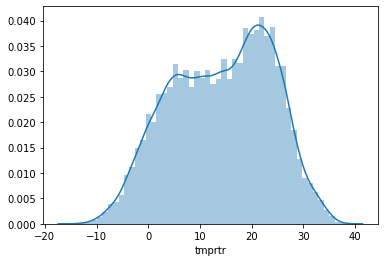

In [38]:
sns.distplot(all_df['tmprtr'])

In [39]:
# 15개의 NaN값을 평균으로 채운다.
tmp_var = all_df['tmprtr']
print('Before number of nan value in "tmprtr":', all_df['tmprtr'].isnull().sum())
all_df['tmprtr'] = all_df['tmprtr'].fillna(all_df['tmprtr'].mean())
print('After number of nan value in "tmprtr":', all_df['tmprtr'].isnull().sum())


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
scaler = MinMaxScaler()
all_df["ntmprtr"] = minmax_scale(all_df['tmprtr'])

Before number of nan value in "tmprtr": 15
After number of nan value in "tmprtr": 0


### prcpttn (강수량) 

In [40]:
all_df["prcpttn"].isnull().sum()

62721

In [41]:
all_df.shape, all_df["prcpttn"].isnull().sum() / all_df.shape[0] * 100

((69054, 178), 90.82891650013033)

In [42]:
del all_df['prcpttn']

### wnd_spd (풍속)

In [43]:
print('Before number of nan value in "wnd_spd":', all_df["wnd_spd"].isnull().sum())

# 평균으로 풍속 대치
all_df['wnd_spd'] = all_df['wnd_spd'].fillna(all_df['wnd_spd'].mean())
print('After number of nan value in "wnd_spd":', all_df["wnd_spd"].isnull().sum())

all_df['wnd_spd'].isnull().sum()
all_df['wnd_spd'] = minmax_scale(all_df['wnd_spd'])

Before number of nan value in "wnd_spd": 38
After number of nan value in "wnd_spd": 0


### wnd_drctn (풍향)

In [44]:
print("ratio of na in total data:", all_df['wnd_drctn'].isnull().sum() / all_df.shape[0] * 100)

# impute na value with mean of wnd_drctn
print('Before number of nan value in "wnd_drctn":', all_df["wnd_drctn"].isnull().sum())
all_df['wnd_drctn'] = all_df['wnd_drctn'].fillna(all_df['wnd_drctn'].mean())

print('After number of nan value in "wnd_drctn":', all_df["wnd_drctn"].isnull().sum())
all_df['wnd_drctn'] = minmax_scale(all_df['wnd_drctn'])

ratio of na in total data: 0.3432096620036493
Before number of nan value in "wnd_drctn": 237
After number of nan value in "wnd_drctn": 0


### hmdt (습도)

In [45]:
print("ratio of na in total data:", all_df['hmdt'].isnull().sum() / all_df.shape[0] * 100)

# impute na value with mean of wnd_drctn
print('Before number of nan value in "hmdt":', all_df["hmdt"].isnull().sum())
all_df['hmdt'] = all_df['hmdt'].fillna(all_df['hmdt'].mean())

print('After number of nan value in "hmdt":', all_df["hmdt"].isnull().sum())
all_df['hmdt'] = minmax_scale(all_df['hmdt'])

ratio of na in total data: 0.03909983491180815
Before number of nan value in "hmdt": 27
After number of nan value in "hmdt": 0


In [46]:
# 중간 확인
all_df[['tmprtr', 'wnd_spd', 'wnd_drctn']]

,tmprtr,wnd_spd,wnd_drctn
0,10.7,0.058824,0.555556
1,19.5,0.032680,0.055556
2,15.5,0.130719,0.250000
3,20.6,0.026144,0.000000
4,12.7,0.039216,1.000000
...,...,...,...
69049,20.3,0.169935,0.555556
69050,16.7,0.104575,0.305556
69051,23.9,0.241830,0.888889
69052,21.1,0.084967,0.305556


### ele_engry_us & gas_engry_us

In [47]:
all_df['ele_engry_us_201401'].isnull().sum()

29132

In [48]:
all_df['gas_engry_us_'].isnull().sum()

KeyError: 'gas_engry_us_'

In [49]:
import re

col_list = all_df.columns
ele_text = re.compile('^ele_engry_us_*')
gas_text = re.compile('^gas_engry_us_*')


ele_list = [ele for ele in col_list if ele_text.findall(ele)]
gas_list = [gas for gas in col_list if gas_text.findall(gas)]


print("number of ele months:", len(ele_list))
print("number of gas months:", len(gas_list))

# ele: 2014.01 ~ 12, 2015.01 ~ 12, 2016.01 ~ 12, 2017.01 ~ 12, 2018.01 ~ 12
# gas: 2014.01 ~ 12, 2015.01 ~ 12, 2016.01 ~ 12, 2017.01 ~ 12, 2018.01 ~ 12



number of ele months: 60
number of gas months: 60


In [50]:
all_df[ele_list]

,ele_engry_us_201401,ele_engry_us_201402,ele_engry_us_201403,ele_engry_us_201404,ele_engry_us_201405,ele_engry_us_201406,ele_engry_us_201407,ele_engry_us_201408,ele_engry_us_201409,ele_engry_us_201410,...,ele_engry_us_201803,ele_engry_us_201804,ele_engry_us_201805,ele_engry_us_201806,ele_engry_us_201807,ele_engry_us_201808,ele_engry_us_201809,ele_engry_us_201810,ele_engry_us_201811,ele_engry_us_201812
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
monthly_avg_ele = [all_df[mon].mean() for mon in ele_list]

In [107]:
avg_ele_2014 = monthly_avg_ele[0:12]
avg_ele_2015 = monthly_avg_ele[12:24]
avg_ele_2016 = monthly_avg_ele[24:36]
avg_ele_2017 = monthly_avg_ele[36:48]
avg_ele_2018 = monthly_avg_ele[48:]

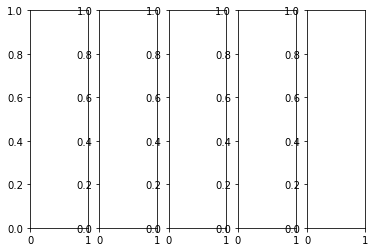

In [113]:
# 분포를 확인해보자

fig, axes = plt.subplots(1,5)